In [ ]:
import pandas as pd, csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pybaseball
from pybaseball import batting_stats_range
from pybaseball import batting_stats
from scipy import stats
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Introduction

Our research question is as follows: are baseball players paid based primarily on their overall ability?
Furthermore, can we identify which predictors beyond a player’s overall ability will increase the
contract they receive and how much will they get paid? The last question we had was could a
general manager use the information we gathered for the benefit of their team, potentially finding
players who the market will undervalue given their overall ability? In this analysis, we will be
focusing on position players due to the lack of compatibility between statistics for pitchers and
position players.

(Have also attached a pdf of the final report submitted for this class)

# Data Cleaning

Our data were sourced from two primary locations. The first was Sportrac.com,
which provided us with year-by-year lists of the MLB free agents and the resulting contracts they
signed. The second was the pybaseball package from github that gave us the statistic for every player we wanted to analyze. Combining these two sources, we were able to get data for every MLB free agent since 2012.

### Combining free agent salaries from all years into a single dataframe

In [ ]:

import os

directory = 'AllFAs'

frames = []

for filename in os.listdir(directory):
    free_agents = []

    new_file = open("AllFAs/" + filename,encoding="utf8")

    read_file = csv.reader(new_file)
    for line in [x for x in read_file]:
        if "(minor)" not in line[0] and " 0 -" not in line and "0 -" not in line and "-" not in line and "P" not in \
                line[1]:
            name = line[0]
            aav = line[9]
            free_agents += [[name] + line[1:9] + [aav] + [int(filename[-8:-4])]]
    frames += free_agents

total_sal = pd.DataFrame(frames, columns = ["Name", "Pos", "Age", "Bats",
                                          "Throws", "Prev_Team", "New_Team",
                                          "Length", "Total", "AAV", "Contract Year"])

total_sal["Season"] = total_sal["Contract Year"] - 1

total_sal

,Name,Pos,Age,Bats,Throws,Prev_Team,New_Team,Length,Total,AAV,Contract Year,Season
0,Robinson Cano,2B,31.1,L,R,NYY,SEA,10,"$240,000,000","$24,000,000",2014,2013
1,Jacoby Ellsbury,CF,30.2,L,L,BOS,NYY,7,"$153,000,000","$21,857,143",2014,2013
2,Shin-Soo Choo,DH,31.4,L,L,CIN,TEX,7,"$130,000,000","$18,571,429",2014,2013
3,Brian McCann,C,29.8,L,R,ATL,NYY,5,"$85,000,000","$17,000,000",2014,2013
4,Curtis Granderson,LF,32.7,L,R,NYY,NYM,4,"$60,000,000","$15,000,000",2014,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
506,Chris Heisey,LF,31.8,R,R,WSH,WSH,1,"$1,400,000","$1,400,000",2017,2016
507,Adam Rosales,2B,33.7,R,R,SD,OAK,1,"$1,250,000","$1,250,000",2017,2016
508,Alexi Amarista,SS,27.7,L,R,SD,COL,1,"$1,250,000","$1,250,000",2017,2016
509,Derek Norris,C,28.1,R,R,WSH,TB,1,"$1,200,000","$1,200,000",2017,2016


In [ ]:
# Retrieving batting statistics
total_stats = pybaseball.batting_stats(2011, 2019, qual= 0)

### Combing batting statistics with salaries for free agents to have our final dataframe

In [ ]:
total_fa = pd.merge(total_sal, total_stats, on= ["Name", "Season"])
total_fa

,Name,Pos_x,Age_x,Bats,Throws,Prev_Team,New_Team,Length,Total,AAV,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,Robinson Cano,2B,31.1,L,R,NYY,SEA,10,"$240,000,000","$24,000,000",...,NaN,NaN,0.0,NaN,0,0.142,0.206,NaN,NaN,NaN
1,Jacoby Ellsbury,CF,30.2,L,L,BOS,NYY,7,"$153,000,000","$21,857,143",...,NaN,NaN,0.0,NaN,0,0.180,0.233,NaN,NaN,NaN
2,Shin-Soo Choo,DH,31.4,L,L,CIN,TEX,7,"$130,000,000","$18,571,429",...,NaN,NaN,0.0,NaN,0,0.178,0.257,NaN,NaN,NaN
3,Brian McCann,C,29.8,L,R,ATL,NYY,5,"$85,000,000","$17,000,000",...,NaN,NaN,0.0,NaN,0,0.184,0.245,NaN,NaN,NaN
4,Curtis Granderson,LF,32.7,L,R,NYY,NYM,4,"$60,000,000","$15,000,000",...,NaN,NaN,0.0,NaN,0,0.182,0.318,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Chris Heisey,LF,31.8,R,R,WSH,WSH,1,"$1,400,000","$1,400,000",...,0.083,110.3,26.0,0.271,96,0.209,0.314,NaN,NaN,NaN
482,Adam Rosales,2B,33.7,R,R,SD,OAK,1,"$1,250,000","$1,250,000",...,0.108,109.7,51.0,0.392,130,0.177,0.324,NaN,NaN,NaN
483,Alexi Amarista,SS,27.7,L,R,SD,COL,1,"$1,250,000","$1,250,000",...,0.009,103.5,28.0,0.241,116,0.197,0.268,NaN,NaN,NaN
484,Derek Norris,C,28.1,R,R,WSH,TB,1,"$1,200,000","$1,200,000",...,0.047,109.0,91.0,0.326,279,0.183,0.294,NaN,NaN,NaN


In [ ]:
# Cleaning salary data
total_fa["AAV"] = [float(x.replace(",","").replace("$", "")) for x in total_fa["AAV"]]

In [ ]:
total_fa["AAV"]

0      24000000.0
1      21857143.0
2      18571429.0
3      17000000.0
4      15000000.0
          ...    
481     1400000.0
482     1250000.0
483     1250000.0
484     1200000.0
485      535000.0
Name: AAV, Length: 486, dtype: float64

# Initial Linear Regression

Our first step was to develop a preliminary regression model based entirely upon the statistic of
wins above replacement, or WAR, to set a baseline for our players' worth. In baseball, WAR is
fundamentally the most important statistic for evaluating a player’s worth by determining how
many wins he is worth to the team more than a replacement player, which in the case of the
MLB, is a minor league talent or a readily available free agent. The calculation for WAR takes
into account many different player efficiency metrics to provide a comprehensive value that
indicates how many additional wins a team would have with this player in the lineup. We will
use WAR as our baseline statistic because winning is definitively the most effective way to
determine team success from a financial standpoint. Winning teams engage fans to a greater
extent, sell more tickets and merchandise, receive more viewership on large networks, and get to
play in playoffs games and contend for a championship. Of course, there are other factors in
determining a team’s relative earnings like market size and history, but from a general manager’s
perspective alone, building a winning team is the best way to ensure revenue

In [ ]:
datatotal = total_fa[["WAR", "Season"]].values
targettotal = total_fa["AAV"].values

linear_modeltotal = LinearRegression()
linear_modeltotal.fit(X = datatotal, y = targettotal)

total_fa["predicted_AAV"] = abs(linear_modeltotal.predict(datatotal))

r2 = r2_score(total_fa["AAV"].values, total_fa["predicted_AAV"].values)
mse = mean_squared_error(total_fa["AAV"].values, total_fa["predicted_AAV"].values)

print("r2 value: ", r2)
print("mse: ", mse)

r2 value:  0.5913674154259216
mse:  12760052180573.506


### Visualizing the correlation of our data

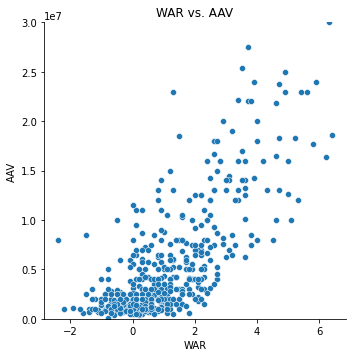

In [ ]:
import matplotlib.pyplot as plt

g = sns.relplot(data=total_fa, x="WAR", y="AAV", ci=None)
g.set(ylim=(0, 3e7))
plt.title("WAR vs. AAV")
plt.savefig('first_model.png')

# Hypothesis Tests and Visualizations

In addition to WAR, we wanted to see which stats cause players to be paid more than their on field value. For example, although home runs are very valuable in baseball, they also bring in a lot of revenue because fans love watching home runs. Therefore, we predicted that players who are overvalued (actual salary received is greater than the predicted salary from our WAR model) would tend to hit more home runs than players that are undervalued. We created hypothesis tests and visualizations to analyze relationships like this one for a few stats or characteristics of players to decide what other stats we should use in order to improve our model.

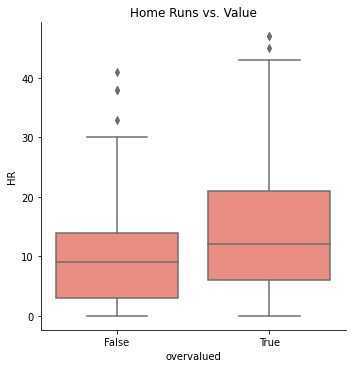

In [ ]:
# Grouping by data that had too low of a prediction vs two high of a prediction

total_fa["overvalued"] = total_fa["predicted_AAV"]<total_fa["AAV"]

#actualsalary_greater = total_fa[total_fa["predicted_AAV"]<total_fa["AAV"]]
#actualsalary_less = total_fa[total_fa["predicted_AAV"]>total_fa["AAV"]]
sns.catplot(x="overvalued", y="HR", data = total_fa, color="salmon", kind="box")
plt.title("Home Runs vs. Value")
plt.savefig("hrvsvalue.png", bbox_inches="tight")

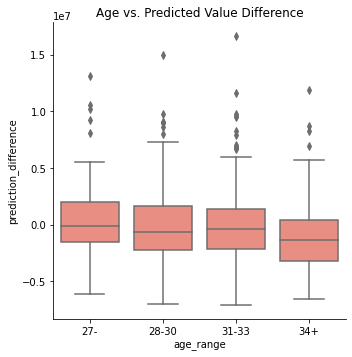

In [ ]:
total_fa["prediction_difference"] = total_fa["AAV"] - total_fa["predicted_AAV"]
total_fa["age_range"] = ["27-" if x <= 27 else "28-30" if x <= 30 else "31-33" if x <= 33 else "34+" for x in total_fa["Age_y"]]

sns.catplot(x="age_range", y="prediction_difference", data = total_fa, color="salmon", kind="box", order= ["27-", "28-30", "31-33", "34+"])
total_fa["prediction_difference"] = total_fa["AAV"] - total_fa["predicted_AAV"]
plt.title("Age vs. Predicted Value Difference")
plt.savefig("value2.png", bbox_inches="tight")

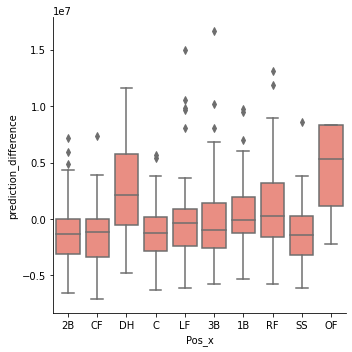

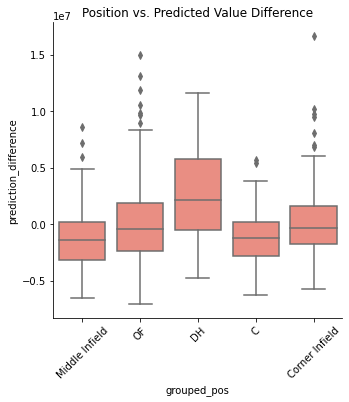

In [ ]:
grouped_posdict = {
    "RF" : "OF",
    "CF" : "OF",
    "LF" : "OF",
    "1B" : "Corner Infield",
    "3B" : "Corner Infield",
    "2B" : "Middle Infield",
    "SS" : "Middle Infield",
    "C" : "C",
    "OF" : "OF",
    "DH" : "DH"
}
total_fa["grouped_pos"] = total_fa['Pos_x'].apply(lambda x: grouped_posdict[x])
sns.catplot(x="Pos_x", y="prediction_difference", data = total_fa, color="salmon", kind="box")
sns.catplot(x="grouped_pos", y="prediction_difference", data = total_fa, color="salmon", kind="box")
plt.xticks(rotation=45)
plt.title("Position vs. Predicted Value Difference")
plt.savefig("value3.png", bbox_inches="tight")

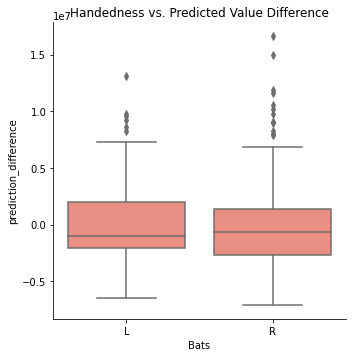

In [ ]:
hittingside_fa = total_fa[(total_fa['Bats']=='L') | (total_fa['Bats']=='R')]

sns.catplot(x="Bats", y="prediction_difference", data = hittingside_fa, color="salmon", kind="box")
plt.title("Handedness vs. Predicted Value Difference")
plt.savefig("value4.png", bbox_inches="tight")

### Hypothesis Tests for our Visualizations

In [ ]:
overvaluedHR = total_fa[total_fa['overvalued']==True]["HR"]
undervaluedHR = total_fa[total_fa['overvalued']==False]["HR"]
hrsig = stats.ttest_ind(overvaluedHR,undervaluedHR)

print(hrsig[1])

1.06119603637964e-06


In [ ]:
batsLeft = total_fa[total_fa['Bats']=="L"]["prediction_difference"]
batsRight = total_fa[total_fa['Bats']=="R"]["prediction_difference"]
batssig = stats.ttest_ind(batsLeft,batsRight)

print(batssig[1])

0.37561406186183977


In [ ]:
overvaluedAge = total_fa[total_fa['overvalued']==True]["Age_y"]
undervaluedAge = total_fa[total_fa['overvalued']==False]["Age_y"]
agesig = stats.ttest_ind(overvaluedAge,undervaluedAge)

print(agesig[1])

print(overvaluedAge.mean())
print(undervaluedAge.mean())

0.004311832788069054
31.00526315789474
31.81756756756757


In [ ]:
overvaluedRBI = total_fa[total_fa['overvalued']==True]["RBI"]
undervaluedRBI = total_fa[total_fa['overvalued']==False]["RBI"]
rbisig = stats.ttest_ind(overvaluedRBI,undervaluedRBI)

print(rbisig[1])

1.1611658969271791e-08


# Final Prediction Model

Using our hypothesis tests and visualizations above, we decided to use home runs, RBIs, age, and position in addition to WAR to improve out model. These stats all had a significant difference in overvalued and undervalued players. Therefore, below we create a second linear regression with an improved r^2 value.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder().fit_transform(total_fa[["grouped_pos"]]).toarray()
datafinal = total_fa[["WAR", "HR", "RBI", "Age_y"]].values
datafinal = np.concatenate((datafinal,OHE),axis=1)

targetfinal = total_fa["AAV"].values

linear_modelfinal = LinearRegression()
linear_modelfinal.fit(X = datafinal, y = targetfinal)

total_fa["predicted_AAV"] = abs(linear_modelfinal.predict(datafinal))

r2final = r2_score(total_fa["AAV"].values, total_fa["predicted_AAV"].values)
msefinal = mean_squared_error(total_fa["AAV"].values, total_fa["predicted_AAV"].values)

print("r2 value: ", r2final)
print("mse: ", msefinal)

r2 value:  0.6641524003617575
mse:  10487252015330.793


### Grouping data by if over/undervalued

In [ ]:
conditions = [abs((total_fa["predicted_AAV"]-total_fa["AAV"])/total_fa["AAV"])<=.3,
total_fa["predicted_AAV"]<total_fa["AAV"],
total_fa["predicted_AAV"]>total_fa["AAV"]]

choices = ["Properly Valued", "Overvalued", "Undervalued"]
total_fa["value"] = np.select(conditions, choices, default="Undervalued")

### Final Model to Predict General Whether a player is overvalued, properly valued, or undervalued

Because there is a great deal of variation in professional baseball contracts due to outside factors like ticket sales, jersey sales, et cetera, we decided to have our model generally predict if a player would be overvalued, undervalued, or properly valued (within 30% of the actual salary) based on our WAR model. 

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

OHE = OneHotEncoder().fit_transform(total_fa[["grouped_pos"]]).toarray()
data = total_fa[["HR", "RBI", "Age_y", "WAR"]]
data = np.concatenate((data,OHE),axis=1)

target = total_fa["value"]
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.3, random_state=210)

kn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={"n_neighbors": range(1,30)})
kn_search.fit(train_data, train_target)
n = kn_search.best_params_["n_neighbors"]
score = kn_search.score(test_data, test_target)

msescore = mean_squared_error(total_fa["AAV"].values, total_fa["predicted_AAV"].values)
print("Nearest Neighbors", n)
print("Accuracy Score: ", score)

Nearest Neighbors 25
Accuracy Score:  0.5205479452054794


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


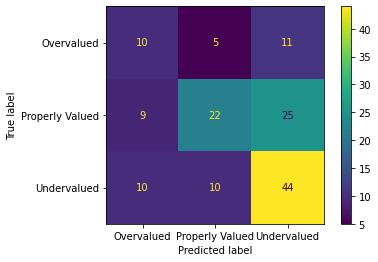

In [ ]:
plot_confusion_matrix(kn_search, test_data, test_target)

plt.grid(False)

## Short Final Analysis

Although not perfect with a 52% accuracy score, our model performs much better than random guessing which would only receive an accuracy score of 33%. Therefore, we were able to achieve some success from our analysis and work, but there are clearly many other factors that influence a players payment in addition to their batting statistics. In order to improve our model, we could analyze fielding statistics along with information on how they affect the revenue of a franchise. We believe that these factors would allow us to greatly improve our model.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cad5b7ea-502f-42d1-8761-40c4dfdd22eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>